# Objectif

### Présentation de la partie 3

1. Mettre en place un modèle prédictif pour la prédiction de la demande hebdomadaire.


2. Utiliser un modèle pour obtenir la demande sur l'ensemble des produits et extraire les prévisions pour le produit 16 dans le magasin 5


3. Developper un outil d'aide à la décision pour piloter les réapprovisionnements à partir des prévisions de vente. Application au cas du produit 16 dans le magasin 5.

Les entrées de l'outil sont :
    - Les prévisions pour les 4 prochaines semaines obtenues à partir du modèle prédictif
    - Le delai de réapprovisionnement : 1 semaine
    - Le prix d'achat : 5 €
    - Le prix de vente : 9 €
    - Le coût de livraison : 2000 €
    - Stock initial : 6000
    - Le coût du stock : 200 % par an "par € de stock"
    - Taux de service cible : 98 %
    
Les sorties sont :
    - Les recommandations de réapprovisionnement
    - Le niveau et le coût de stock par semaine 
    - Le niveau de service 

### Livrables pour jeudi 14h
- Une copie de votre notebook de travail
- Vos previsions pour l'ensemble des produits et des magasins
- L'outil de réapprovisionnement avec l'application sur le produit 16 dans le magasin 5
- Une présentation expliquant votre démarche 

### Présenation finale vendredi
- Echange de 15 min par groupe (10 min de présentation / 5 min de questions ) vendredi après-midi

## Importation des modules Python

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from model import (Modeling, train_test_split_by_date, 
                             series_to_supervised, LightGBM_Modeling)
import utils
from sklearn.preprocessing import LabelEncoder

sns.set_style("ticks")

# Collecte des données

## Importer les données

In [3]:
train_df = pd.read_csv('././data/train_part_three.csv')
features_df = pd.read_csv('././data/features.csv')

# Préparation des données

## Nettoyage des données

In [4]:
# Fusionner les tables
data_df = train_df.merge(features_df, on = ["Store", "Date", "IsHoliday"], how="left" )

# Les données sont déjà propres

## Feature engineering

Variables du jeu de données

- **Date** - the week
- **Weekly_Sales** -  sales for the given department in the given store
- **IsHoliday** - whether the week is a special holiday week
- **Store** - the store number
- **Temperature** - average temperature in the region
- **Fuel_Price** - cost of fuel in the region
- **MarkDown1-5** - anonymized data related to promotional markdowns that the store is running. MarkDown data is only available after Nov 2011, and is not available for all stores all the time. Any missing value is marked with an NA.
- **CPI** - the consumer price index
- **Unemployment** - the unemployment rate
- **IsHoliday** - whether the week is a special holiday week



Comme dans la partie 2 de cette étude de cas, les première varibales que l'on va extraire de notre base de données sont les varibles issues de la date (semaine, moi, année et timepoint)

In [5]:
data_df["Month"] = pd.DatetimeIndex(data_df['Date']).month
data_df['Year'] = pd.DatetimeIndex(data_df['Date']).year
data_df['Week'] = pd.DatetimeIndex(data_df['Date']).week
le = LabelEncoder()
data_df["Timepoint"] = le.fit_transform(data_df["Date"])

## Visualisation des données

In [6]:
data_df.head()

Store  Item        Date  Weekly_Sales  IsHoliday  Temperature  Fuel_Price  \
0      1     1  2010-02-05         24924      False        42.31       2.572   
1      1     1  2010-02-12         46039       True        38.51       2.548   
2      1     1  2010-02-19         41595      False        39.93       2.514   
3      1     1  2010-02-26         19403      False        46.63       2.561   
4      1     1  2010-03-05         21827      False        46.50       2.625   

   MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  \
0        NaN        NaN        NaN        NaN        NaN  211.096358   
1        NaN        NaN        NaN        NaN        NaN  211.242170   
2        NaN        NaN        NaN        NaN        NaN  211.289143   
3        NaN        NaN        NaN        NaN        NaN  211.319643   
4        NaN        NaN        NaN        NaN        NaN  211.350143   

   Unemployment  Month  Year  Week  Timepoint  
0         8.106      2  2010     5          0  
1         8.106      2  2010     6          1  
2         8.106      2  2010     7          2  
3         8.106      2  2010     8          3  
4         8.106      3  2010     9          4

Vous effectuerez des analyses uni-variée et multi-variée en traçant des distributions pour comprendre les données et identifier les variables pertinentes à prendre en compte dans la modélisation.

Fonctions proposées:
- utils.get_individual_sales_info(df, store_number=None, item_number=None), 
- utils.plot_sales(df, store_number=None, item_number=None, ax=None, time_unit='Date', histogram=False, groupby=[], agg='mean')
- utils.get_average_sales( df, item_number, store_number, time_unit, groupby=[], agg='mean')
- utils.plot_sales_per_store_item(df, item_number=None, store_number=None, ax=None, agg='sum')

Vous pouvez aussi explorer les données avec vos propres fonctions.

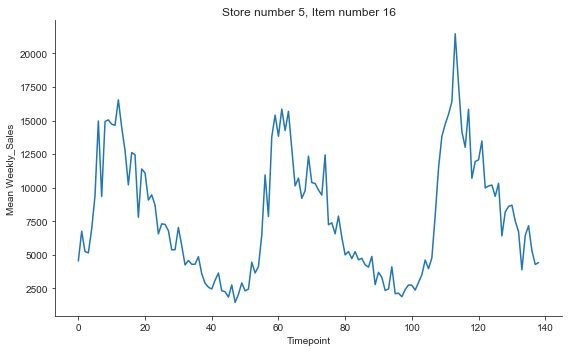

In [7]:
utils.plot_sales(data_df, store_number=5, item_number=16, time_unit="Timepoint")

Dans un deuxième temps on va pouvoir sélectionner les variables que l'on veut considérer pour le modèle :

In [8]:
#on regroupe dans chosen_features les données o
chosen_features = [
    "Weekly_Sales", "IsHoliday", "Temperature", "Fuel_Price", "CPI",
    "Unemployment", "Month", "Year", "Week", "Timepoint", "Store","Item"
]

Une techniques très utilisée mais que nous ne vous avons pas présenté lors du cours est le lag. L'idée est la suivante. On va inclure les variables explicatives et les ventes des semaines précédentes pour expliquer le vente d'une semaine données.

la fonction series_to_supervised(data, target, n_in=1, n_out=1, dropnan=False) peut être utilisée pour réaliser cette tache

- data: Sequence of observations as a list or NumPy array.
- target: Sequence of targets as a list or NumPy array
- n_in: Number of lag observations as input (X).
- n_out: Number of observations as output (y).
- dropnan: Boolean whether or not to drop rows with NaN values.


In [9]:
#on regroupe dans add_features les données où l'on souhaite introduire un lag
add_features = [ "Weekly_Sales",  "Temperature", "Fuel_Price", "CPI",
    "Unemployment"]

add_df = series_to_supervised(data_df[add_features], "Weekly_Sales", n_in=1, n_out=0)

Enfin il faut regrouper les variables sélectionnées et les variables de lag ensembles

In [10]:
merge_data = data_df[chosen_features].merge(add_df, left_index=True, right_index = True)

In [11]:
merge_data.head()

Weekly_Sales  IsHoliday  Temperature  Fuel_Price         CPI  Unemployment  \
0         24924      False        42.31       2.572  211.096358         8.106   
1         46039       True        38.51       2.548  211.242170         8.106   
2         41595      False        39.93       2.514  211.289143         8.106   
3         19403      False        46.63       2.561  211.319643         8.106   
4         21827      False        46.50       2.625  211.350143         8.106   

   Month  Year  Week  Timepoint  Store  Item  Weekly_Sales(t-1)  \
0      2  2010     5          0      1     1                NaN   
1      2  2010     6          1      1     1            24924.0   
2      2  2010     7          2      1     1            46039.0   
3      2  2010     8          3      1     1            41595.0   
4      3  2010     9          4      1     1            19403.0   

   Temperature(t-1)  Fuel_Price(t-1)    CPI(t-1)  Unemployment(t-1)  
0               NaN              NaN         NaN                NaN  
1             42.31            2.572  211.096358              8.106  
2             38.51            2.548  211.242170              8.106  
3             39.93            2.514  211.289143              8.106  
4             46.63            2.561  211.319643              8.106

## Train test split

In [12]:
X_train, X_test, y_train, y_test = train_test_split_by_date(merge_data, target="Weekly_Sales", train_size=0.8)

In [13]:
null_index = X_train[X_train.isnull().any(axis=1)].index
new_X_train = X_train.drop(null_index)
new_y_train = y_train.drop(null_index)

# Exemple avec l'algorithme fôret aléatoire de sklearn

In [14]:
from sklearn.ensemble import RandomForestRegressor

clf_rf = RandomForestRegressor()
CV = False

if CV:
    params = {
        "n_estimators": np.arange(20, 140, 20),
        "max_depth": np.arange(2, 8, 2),
        "min_samples_leaf": np.arange(2, 8, 2)
    }
    rf_model = Modeling(clf_rf)
    cv_results = rf_model.cv(new_X_train, new_y_train, params)
    best_params = cv_results.best_params_
else:
    best_params = {"n_estimators": 20,  "max_depth":2, "min_samples_leaf":2}
    
model = RandomForestRegressor(**best_params)
m = Modeling(model)
m.fit(new_X_train, new_y_train)
y_pred = m.predict(X_test)
y_train_pred = m.predict(new_X_train)
eval_duplication = m.evaluation(new_y_train,
                                y_train_pred,
                                y_test,
                                y_pred,
                                method=["mae"],
                                verbose=True)

    

Train score (mae) : 5156.90
Test score (mae) : 4705.22


## Visualisation de l'importance des variables dans le modèle

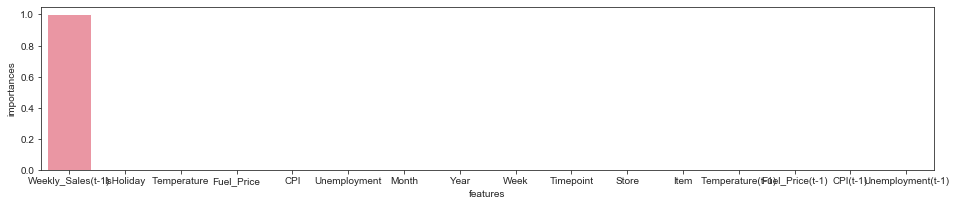

In [15]:
fig, ax = plt.subplots(figsize=(16,3))
features = new_X_train.columns.tolist()
m.feature_importances(ax, features);

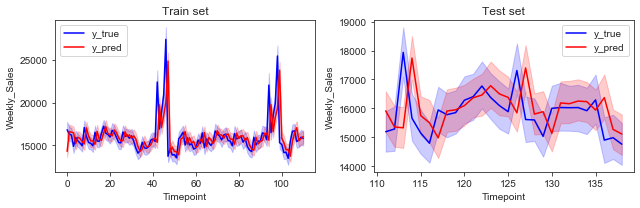

In [16]:
fig, ax = plt.subplots(1,2, figsize=(9,3))
m.prediction_visualization(new_X_train["Timepoint"], new_y_train, y_train_pred, ax=ax[0])
ax[0].set_title("Train set")
m.prediction_visualization(X_test["Timepoint"], y_test, y_pred, ax=ax[1])
ax[1].set_title("Test set")
plt.tight_layout()

Random forest ne considère que le WeeklySales précédente comme feature importante. Le test score est 4705.25.

# Exemple avec la méthode XGBoost 
Méthode boosting avec le module LightGBM et plus de paramètres

## Creation du modèle, préparation des variables et entrainement du modèle

In [17]:
lgbm = LightGBM_Modeling()
train_data, validation_data = lgbm.prepare_dataset(X_train, X_test, y_train, y_test)
bst = lgbm.fit(train_data, validation_data)

[1]	valid_0's l1: 14058.6
Training until validation scores don't improve for 5 rounds
[2]	valid_0's l1: 12684.9
[3]	valid_0's l1: 11458.9
[4]	valid_0's l1: 11310.9
[5]	valid_0's l1: 10224.4
[6]	valid_0's l1: 9248.17
[7]	valid_0's l1: 8374.64
[8]	valid_0's l1: 7591.67
[9]	valid_0's l1: 7123.85
[10]	valid_0's l1: 6472.04
[11]	valid_0's l1: 6402.35
[12]	valid_0's l1: 5835.07
[13]	valid_0's l1: 5329.21
[14]	valid_0's l1: 4874.72
[15]	valid_0's l1: 4622.02
[16]	valid_0's l1: 4256.44
[17]	valid_0's l1: 3934.63
[18]	valid_0's l1: 3648.27
[19]	valid_0's l1: 3637.26
[20]	valid_0's l1: 3628.34
[21]	valid_0's l1: 3393.94
[22]	valid_0's l1: 3182.91
[23]	valid_0's l1: 3192.68
[24]	valid_0's l1: 3177.73
[25]	valid_0's l1: 3004.3
[26]	valid_0's l1: 2911.96
[27]	valid_0's l1: 2830.1
[28]	valid_0's l1: 2691.59
[29]	valid_0's l1: 2632.65
[30]	valid_0's l1: 2623.51
[31]	valid_0's l1: 2521.23
[32]	valid_0's l1: 2483.1
[33]	valid_0's l1: 2414.02
[34]	valid_0's l1: 2343.56
[35]	valid_0's l1: 2351.7
[36]	val

## Visualisation de l'importance des variables dans le modèle

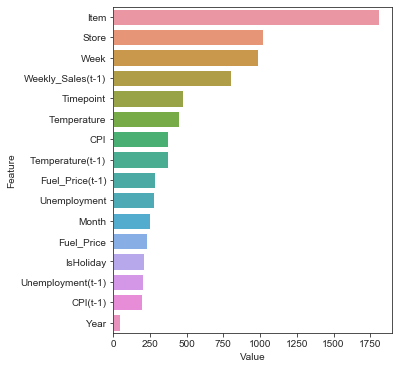

In [18]:
fig, ax = plt.subplots(figsize=(5,6))
features = X_train.columns.tolist()
feature_importance = lgbm.feature_importances(ax, features)

On voit que le modèle considère la variable Item comme le facteur le plus important dans la prédiction.

## Test du modèle

Train score (mae) : 1951.05
Test score (mae) : 1998.01


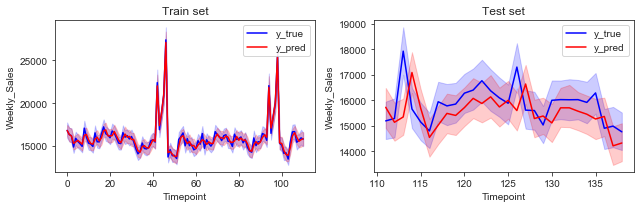

In [19]:
y_pred_train = bst.predict(X_train)
y_pred_test = bst.predict(X_test)
eval_score = lgbm.evaluation(y_train, y_pred_train,
                        y_test, y_pred_test, method=["mae"], verbose=True)
fig, ax = plt.subplots(1,2, figsize=(9,3))
lgbm.prediction_visualization(X_train["Timepoint"], y_train, y_pred_train, ax=ax[0])
ax[0].set_title("Train set")
lgbm.prediction_visualization(X_test["Timepoint"], y_test, y_pred_test, ax=ax[1])
ax[1].set_title("Test set")
plt.tight_layout()

Avec les variables fournies par la base de données, nous avons une MAE pour le test score de 1998.01.

In [20]:
# A vous de joueur 